In [1]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Load Datasets

In [1]:
#!pip install --upgrade datasets fsspec

## **Dataset Evaluation**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
hate_df = pd.read_csv("/content/drive/MyDrive/hate_detect_tweets.csv")
hate_df

,text,hatespeech,language,target,directness,annotator_sentiment,group
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0,arabic,normal,normal,normal,normal
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0,arabic,normal,normal,normal,normal
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0,arabic,normal,normal,normal,normal
3,اي كذبه فيهم,0,arabic,normal,normal,normal,normal
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0,arabic,normal,normal,normal,normal
...,...,...,...,...,...,...,...
38176,"Please help support nonbinary pride, add a #Tw...",0,english,normal,normal,normal,normal
38177,I love that you enjoy being trans.,0,english,normal,normal,normal,normal
38178,I've always been proud of the Igbo tribe and o...,0,english,normal,normal,normal,normal
38179,Trans rights are human rights,0,english,normal,normal,normal,normal


array([[<Axes: title={'center': 'hatespeech'}>]], dtype=object)

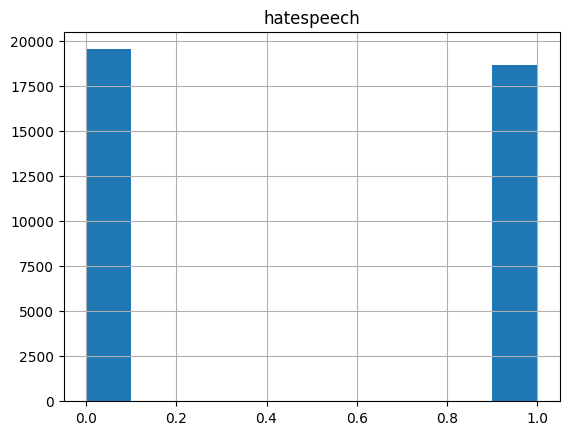

In [4]:
hate_df.hist('hatespeech')

In [5]:
hate_df['language'].value_counts()

,count
language,
english,20814
french,9014
arabic,8353


## Encode Categorical Output Variables

In [6]:
label_maps = {}
for col in ['directness', 'target', 'group']:
    le = LabelEncoder()
    hate_df[col + '_label'] = le.fit_transform(hate_df[col].astype(str))
    # Convert keys to str for JSON compatibility
    label_maps[col] = {str(k): v for k, v in zip(le.transform(le.classes_), le.classes_)}

with open('../label_maps.json', 'w') as f:
    json.dump(label_maps, f)

In [7]:
# Split annotator_sentiment values by "_" and count distinct sentiments

# Drop NaN and split by '_', then flatten the list
all_sentiments = hate_df['annotator_sentiment'].apply(lambda x: x.split('_'))
# all_sentiments
flat_sentiments = [sent for sublist in all_sentiments for sent in sublist]
# flat_sentiments

# Get unique sentiments and their count
unique_sentiments = set(flat_sentiments)
print(f"Distinct annotator sentiments ({len(unique_sentiments)}): {unique_sentiments}")

Distinct annotator sentiments (8): {'normal', 'sadness', 'confusion', 'shock', 'disgust', 'indifference', 'fear', 'anger'}


In [8]:
# Get all unique sentiments
all_sentiments = sorted({s for x in hate_df['annotator_sentiment'].dropna() for s in x.split('_')})

# Multi-hot encode
for sentiment in all_sentiments:
    hate_df[f'sentiment_{sentiment}'] = hate_df['annotator_sentiment'].apply(
        lambda x: int(sentiment in x.split('_')) if isinstance(x, str) else 0
    )
# The columns sentiment_anger, sentiment_confusion, ... are the multi-label targets
print(hate_df.columns)
hate_df.head()

Index(['text', 'hatespeech', 'language', 'target', 'directness',
       'annotator_sentiment', 'group', 'directness_label', 'target_label',
       'group_label', 'sentiment_anger', 'sentiment_confusion',
       'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference',
       'sentiment_normal', 'sentiment_sadness', 'sentiment_shock'],
      dtype='object')


,text,hatespeech,language,target,directness,annotator_sentiment,group,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0
3,اي كذبه فيهم,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0


## Clean Text

In [9]:
# Clean text for all datasets: combined_df, mlma_df, berkeley_df, ar_hf, fr_hf

def clean_text_column(df, text_col='text', new_col='text_cleaned'):
    unwanted_chars = (
        r'@URL', r'@url', r'@user', r'\\ude02', r'\\ud83d', r'\\u2026', r'\\u201c', r'\\u201d', r'\\udc4d', r'\\n', r'\\uffe3',
        r'\\ud83e', r'\\udd26', r'\\u2044', r'\\u25d5', r'\\udd26', r'\\u03c9', r'\\ud83c', r'\\udc80', r'\\udded', r'\\uddf7',
        r'\\u2022', r'\\u25e1', r'\\udffd', r'\\u200d', r'\\u2640', r'\\ude37', r'\\udc40', r'\\ude1f', r'\\udd37', r'\\u2642',
        r'\\ude2d', r'\\udd25', r'\\ude44', r'\\u2018', r'\\u2744', r'\\udff3', r'\\udf08', r'\\udc13', r'\\udd38', r'\\udc4a',
        r'\\ude12', r'\\uddfa', r'\\uddf2', r'\\uded1', r'\\u25b7', r'\\u25c1', r'\\u2665', r'\\uff46', r'\\uff41', r'\\uff45',
        r'\\uff54', r'\\udc47', r'\\udffb', r'\\ude05', r'\\udc4c', r'\\u270b', r'\\udeab', r'\\udfe2', r'\\uddf9', r'\\ude08',
        r'\\udc3e', r'\\ude03', r'\\udca3', r'\\ude0e', r'\\udd23', r'\\udd95', r'\\udf33', r'\\ude1a', r'\\udf8a', r'\\udd2a',
        r'\\u2800', r'\\u275b', r'&amp', r'&gt;', r'&lt;', r'URL'
    )
    df[new_col] = df[text_col].copy()
    df[new_col] = df[new_col].str.replace(r'\\u2019', "'", case=False, regex=True)
    for char in unwanted_chars:
        df[new_col] = df[new_col].str.replace(char, " ", case=False, regex=True)
    df[new_col] = df[new_col].apply(lambda x: re.sub(r'\s+', ' ', x.strip()) if isinstance(x, str) else x)
    return df

hate_df = clean_text_column(hate_df)
hate_df

,text,hatespeech,language,target,directness,annotator_sentiment,group,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,text_cleaned
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...
3,اي كذبه فيهم,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,اي كذبه فيهم
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38176,"Please help support nonbinary pride, add a #Tw...",0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,"Please help support nonbinary pride, add a #Tw..."
38177,I love that you enjoy being trans.,0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,I love that you enjoy being trans.
38178,I've always been proud of the Igbo tribe and o...,0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,I've always been proud of the Igbo tribe and o...
38179,Trans rights are human rights,0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,Trans rights are human rights


In [10]:
# remove @USER from all rows
hate_df.loc[:, 'text'] = hate_df['text'].str.replace(r'@USER', '', regex=True).str.strip().str.replace(r'\s+', ' ', regex=True)

## Visualizations

### Text Length Distributions

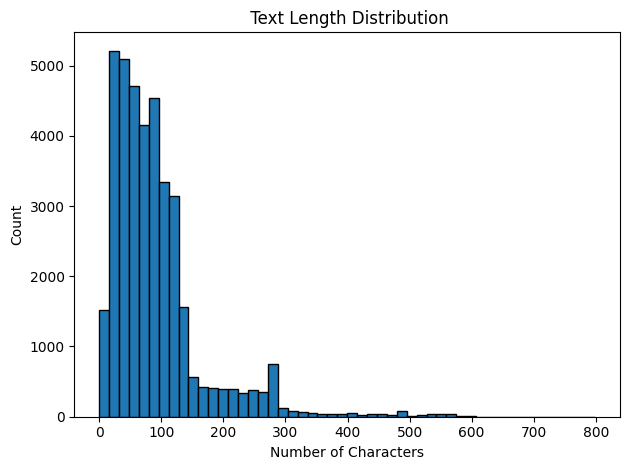

In [11]:
datasets = [
    ("Combined Dataset", hate_df),
]


hate_df['text_length'] = hate_df['text_cleaned'].astype(str).apply(len)
counts, bins, patches = plt.hist(hate_df['text_length'], bins=50, edgecolor='black')
plt.title(f" Text Length Distribution")
plt.ylabel('Count')

#plt.text((bin_left + bin_right) / 2, count, str(int(count)),ha='center', va='bottom', fontsize=7, rotation=45)
plt.xlabel('Number of Characters')
plt.tight_layout()
plt.show()

In [12]:
hate_df['language'].value_counts()

,count
language,
english,20814
french,9014
arabic,8353


In [13]:
# Number English tweets with <= 140 characters in MLMA and Berkeley datasets
print(len(hate_df[(hate_df['text_length'] <= 150) & (hate_df['language'] == 'english')]))
print(len(hate_df[(hate_df['text_length'] <= 150) & (hate_df['language'] == 'french')]))
print(len(hate_df[(hate_df['text_length'] <= 150) & (hate_df['language'] == 'arabic')]))

17537
8053
7976


### DROP LONGER TEXTS

In [14]:
# So the model does not learn to classify based on text length
print(f"Before filtering out long texts: {hate_df.shape}")
hate_df = hate_df[hate_df['text_length'] <= 150]

print(f"After filtering out long texts: {hate_df.shape}")

Before filtering out long texts: (38181, 20)
After filtering out long texts: (33566, 20)


# Dropping longer text caused a data imbalance, mostly for English

  (we dropped 2.5K English rows)

array([[<Axes: title={'center': 'hatespeech'}>]], dtype=object)

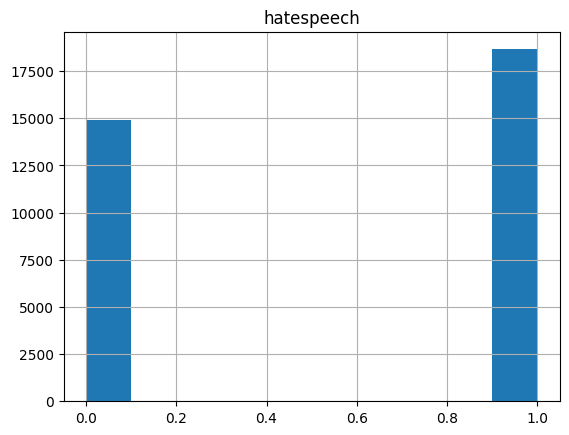

In [15]:
hate_df.hist('hatespeech')

In [16]:
hate_df.to_csv("/content/drive/MyDrive/hate_detect_tweets_clean_unshuffled.csv", index=False)

In [17]:
hate_df

,text,hatespeech,language,target,directness,annotator_sentiment,group,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,text_cleaned,text_length
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,78
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,121
3,اي كذبه فيهم,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,اي كذبه فيهم,12
5,صواريخ وأسلحة العرب ما رح تشوفيها الا بكليبات ...,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,صواريخ وأسلحة العرب ما رح تشوفيها الا بكليبات ...,61
6,عمريي انتي مانحرم,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,عمريي انتي مانحرم,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38176,"Please help support nonbinary pride, add a #Tw...",0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,"Please help support nonbinary pride, add a #Tw...",56
38177,I love that you enjoy being trans.,0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,I love that you enjoy being trans.,34
38178,I've always been proud of the Igbo tribe and o...,0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,I've always been proud of the Igbo tribe and o...,140
38179,Trans rights are human rights,0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,Trans rights are human rights,29


# Shuffle

In [18]:
shuffled_df = hate_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
shuffled_df

,text,hatespeech,language,target,directness,annotator_sentiment,group,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,text_cleaned,text_length
0,@user Because with out the illegal aliens voti...,1,english,origin,indirect,anger_confusion_sadness_shock_indifference,left_wing_people,1,3,10,1,1,0,0,1,0,1,1,Because with out the illegal aliens voting.. t...,67
1,elle propose des informations sur l'avortement...,1,french,origin,direct,confusion_sadness_shock_indifference_disgust,individual,0,3,8,0,1,1,0,1,0,1,1,elle propose des informations sur l'avortement...,115
2,@user fucking raghead cunts,1,english,origin,direct,confusion_fear_indifference_sadness_disgust,women,0,3,16,0,1,1,1,1,0,1,0,fucking raghead cunts,21
3,black youtubers: demonetized say nigger ????? ...,1,english,origin,indirect,anger_disgust,jews,1,3,9,1,0,1,0,0,0,0,0,black youtubers: demonetized say nigger ????? ...,77
4,et non il n’y pas plus de crimes commis par de...,0,french,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,et non il n’y pas plus de crimes commis par de...,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33561,wowwww nigger @url,1,english,origin,indirect,anger_confusion_fear_shock_sadness,other,1,3,13,1,1,0,1,0,0,1,1,wowwww nigger,13
33562,yuri ct la miff il posé ses couilles contre le...,0,french,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,yuri ct la miff il posé ses couilles contre le...,87
33563,لازم تبقي وسخ عشان تعجب تقريبا الايام دي,1,arabic,other,indirect,indifference,individual,1,4,8,0,0,0,0,1,0,0,0,لازم تبقي وسخ عشان تعجب تقريبا الايام دي,40
33564,: راحة نفسية,0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,: راحة نفسية,12


In [20]:
shuffled_df.to_csv("/content/drive/MyDrive/hate_detect_tweets_clean_shuffled.csv", index=False)

## Split, and Export Datasets

In [22]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

def iterative_split_and_export(df, prefix):
    # Identify feature and label columns
    label_cols = [col for col in df.columns if col.startswith('sentiment_')]
    feature_cols = [col for col in df.columns if col not in label_cols]

    # Convert to numpy arrays
    X = df[feature_cols].values
    y = df[label_cols].values.astype(int)

    # First split: train (80%), temp (20%)
    X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.2)
    # Second split: val (10%), test (10%) from temp
    X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

    # Convert back to DataFrames
    train_df = pd.DataFrame(np.hstack([X_train, y_train]), columns=feature_cols + label_cols)
    val_df = pd.DataFrame(np.hstack([X_val, y_val]), columns=feature_cols + label_cols)
    test_df = pd.DataFrame(np.hstack([X_test, y_test]), columns=feature_cols + label_cols)

    # Ensure correct dtypes for integer columns
    for col in label_cols + ['directness_label', 'target_label', 'group_label', 'hatespeech']:
        if col in train_df.columns:
            train_df[col] = train_df[col].astype(int)
            val_df[col] = val_df[col].astype(int)
            test_df[col] = test_df[col].astype(int)

    # Filter wanted columns
    cols_to_keep = [
        'text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech'
    ] + label_cols
    train_export = train_df[cols_to_keep]
    val_export = val_df[cols_to_keep]
    test_export = test_df[cols_to_keep]

    # Output to CSV
    train_export.to_csv(f"/content/drive/MyDrive/{prefix}_train.csv", index=False)
    val_export.to_csv(f"/content/drive/MyDrive/{prefix}_val.csv", index=False)
    test_export.to_csv(f"/content/drive/MyDrive/{prefix}_test.csv", index=False)

    print(f"{prefix.capitalize()} Train size: {train_export.shape}")
    print(f"{prefix.capitalize()} Validation size: {val_export.shape}")
    print(f"{prefix.capitalize()} Test size: {test_export.shape}")
    return train_export.head()

# For combined_df
iterative_split_and_export(shuffled_df, "combined")

# For english_df
english_df = shuffled_df[shuffled_df['language'] == 'english'].reset_index(drop=True)
iterative_split_and_export(english_df, "english")
# For french_df
french_df = shuffled_df[shuffled_df['language'] == 'french'].reset_index(drop=True)
iterative_split_and_export(french_df, "french")
# For arabic_df
arabic_df = shuffled_df[shuffled_df['language'] == 'arabic'].reset_index(drop=True)
iterative_split_and_export(arabic_df, "arabic")

Combined Train size: (26850, 14)
Combined Validation size: (3359, 14)
Combined Test size: (3357, 14)
English Train size: (13954, 14)
English Validation size: (1764, 14)
English Test size: (1819, 14)
French Train size: (6426, 14)
French Validation size: (813, 14)
French Test size: (814, 14)
Arabic Train size: (6385, 14)
Arabic Validation size: (794, 14)
Arabic Test size: (797, 14)


,text_cleaned,language,directness_label,target_label,group_label,hatespeech,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock
0,يا رب ابوي ما يدري بالقصه,arabic,2,2,12,0,0,0,0,0,0,1,0,0
1,مفاعل نووي ام يبحثون عن بول البعير,arabic,1,3,13,1,1,0,1,0,0,0,0,0
2,خلاص ليه نص ساعة يخدم,arabic,2,2,12,0,0,0,0,0,0,1,0,0
3,الدكتور القوي هو الي بخلي اشي من مادة السكند ا...,arabic,2,2,12,0,0,0,0,0,0,1,0,0
4,ليت يجي قرار يمنع الحريم من التغريد عن الرياضة.,arabic,1,1,16,1,1,1,1,0,1,0,1,0


In [21]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Action items
# shuffle dataset
# ask mark on friday if we should truncate, keep long text or remove completely
# mbert : bella, XLMroberta- base : nadaa , roberta-large
# write the paper